In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, time
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm_notebook
import kornia
from torchvision.utils import save_image
from IPython.core.display import Image, display

from utils import show_train_hist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128, n_classes=10):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(n_classes, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128, n_classes=10):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(n_classes, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d//2, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1+n_classes, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, images):
        x = F.leaky_relu(self.conv1_1(images), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = self.conv4(x)
        return torch.sigmoid(x[:, :1]), torch.log_softmax(x[:, 1:], dim=1)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [39]:
# training parameters
batch_size = 128*2
lr = 0.0002 / 3
train_epoch = 50
img_size = 32

transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

# n_classes = 10
# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST('data', train=True, download=True, transform=transform),
#     batch_size=batch_size, shuffle=True)

n_classes = 128
dataloader = torch.utils.data.DataLoader(
    datasets.EMNIST('data', 'balanced', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# from symbols_dataset import make_loader
# n_classes = 22
# dataloader, dataset = make_loader(batch_size, img_size)


root = 'results/'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

onehot = torch.zeros(n_classes, n_classes)
onehot = onehot.scatter_(1, torch.LongTensor(np.arange(n_classes)).view(n_classes, 1), 1).view(n_classes, n_classes, 1, 1)
fill = torch.zeros([n_classes, n_classes, img_size, img_size])
for i in range(n_classes):
    fill[i, i, :, :] = 1

fill.cuda()
onehot.cuda()

# fixed noise & label
num_fixed = 128
fixed_z = torch.randn((num_fixed, 100, 1, 1)).cuda()
fixed_y = torch.zeros(num_fixed).long()
fixed_y_label = torch.zeros(num_fixed, n_classes, 1, 1).cuda()
for i in range(num_fixed):
    fixed_y_label[i, i, :, :] = 1


In [40]:
def show_result(G, path = 'result.png'):
    test_images = G(fixed_z, fixed_y_label)
    test_images = (test_images.cpu() + 1) * 0.5
    test_images = test_images.data.view(num_fixed, 1, 32, 32)
    save_image(test_images, path, nrow=16, padding=1, pad_value=1, scale_each=False, normalize=False)
    display(Image(path))

training start!


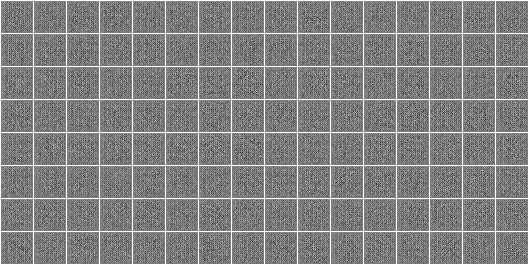

[1/50] - ptime: 0.87, loss_d: 6.517, loss_g: 1.320
tensor(5.1001)


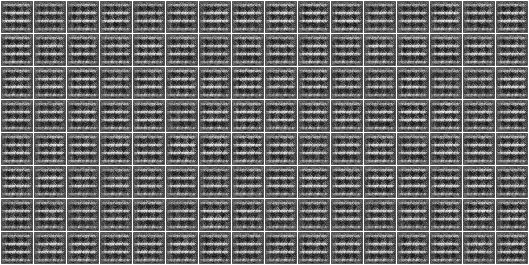

[1/50] - ptime: 137.99, loss_d: 1.107, loss_g: 3.711
tensor(0.8867)


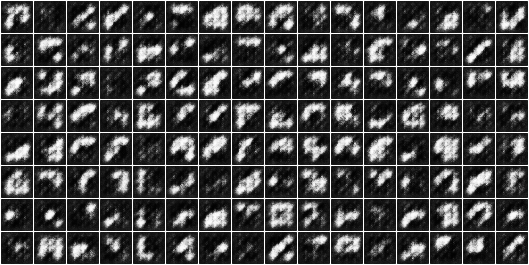

[1/50] - ptime: 276.01, loss_d: 0.662, loss_g: 4.225
tensor(0.4837)


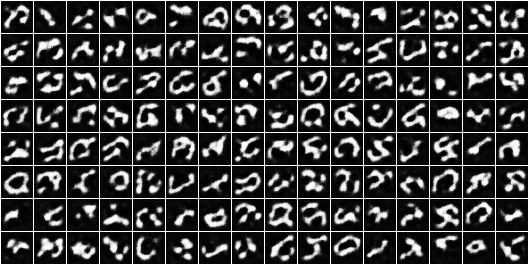

[2/50] - ptime: 110.69, loss_d: 0.390, loss_g: 3.284
tensor(0.0653)


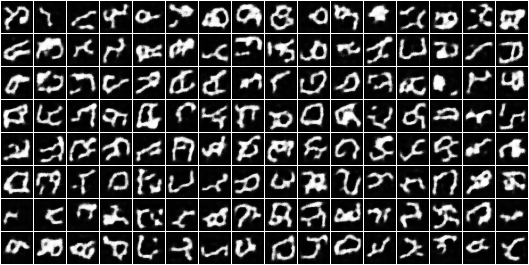

[2/50] - ptime: 248.94, loss_d: 0.530, loss_g: 2.511
tensor(0.0473)


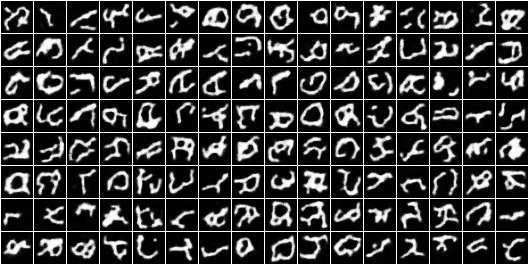

[3/50] - ptime: 82.36, loss_d: 0.752, loss_g: 1.377
tensor(0.0221)


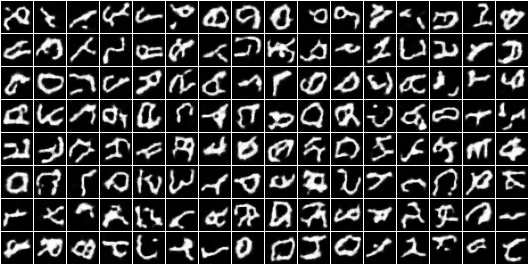

[3/50] - ptime: 220.55, loss_d: 0.758, loss_g: 1.369
tensor(0.0200)


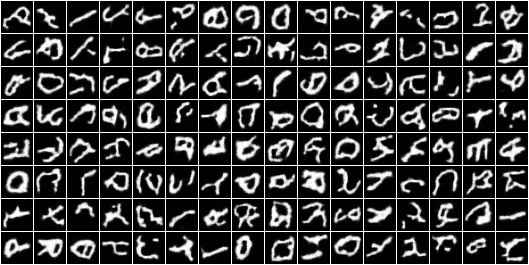

[4/50] - ptime: 54.10, loss_d: 0.791, loss_g: 1.287
tensor(0.0163)


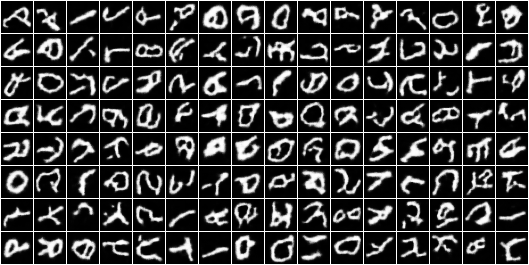

[4/50] - ptime: 192.27, loss_d: 0.807, loss_g: 1.269
tensor(0.0155)


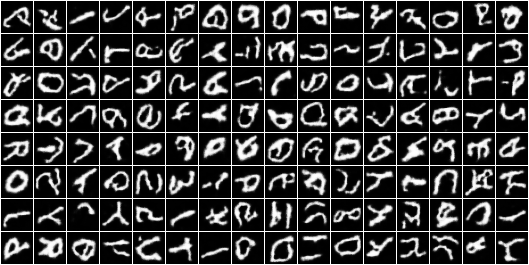

[5/50] - ptime: 25.79, loss_d: 0.837, loss_g: 1.178
tensor(0.0139)


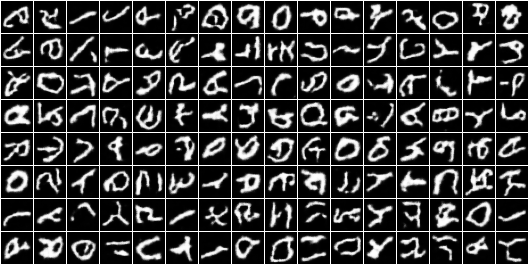

[5/50] - ptime: 163.99, loss_d: 0.848, loss_g: 1.196
tensor(0.0133)


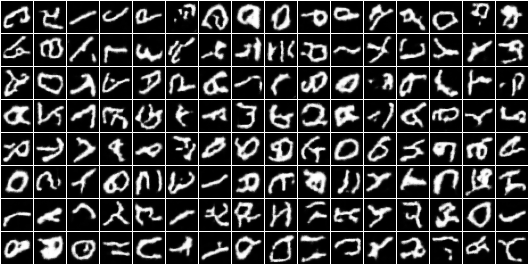

[5/50] - ptime: 302.16, loss_d: 0.858, loss_g: 1.191
tensor(0.0128)


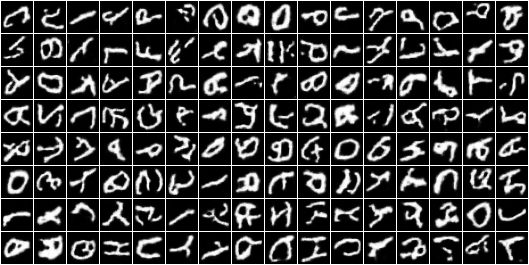

[6/50] - ptime: 135.50, loss_d: 0.855, loss_g: 1.176
tensor(0.0109)


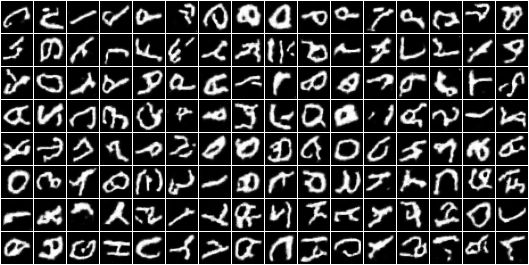

[6/50] - ptime: 273.74, loss_d: 0.855, loss_g: 1.180
tensor(0.0105)


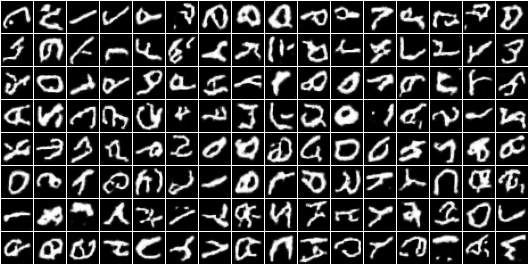

[7/50] - ptime: 107.18, loss_d: 0.838, loss_g: 1.189
tensor(0.0094)


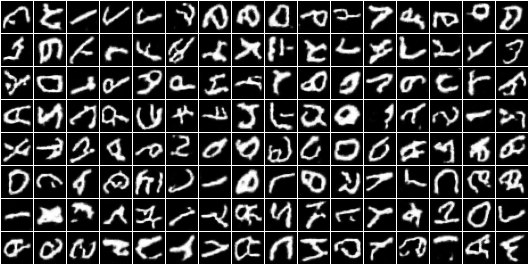

[7/50] - ptime: 245.35, loss_d: 0.851, loss_g: 1.182
tensor(0.0093)


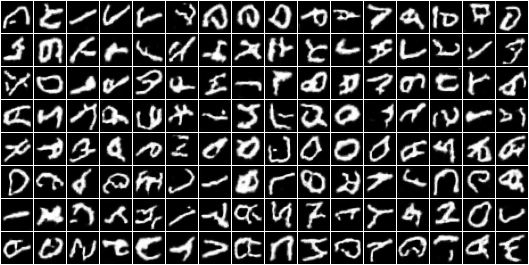

[8/50] - ptime: 78.93, loss_d: 0.832, loss_g: 1.172
tensor(0.0087)


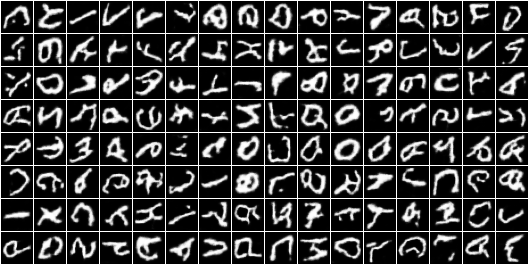

[8/50] - ptime: 217.14, loss_d: 0.837, loss_g: 1.179
tensor(0.0083)


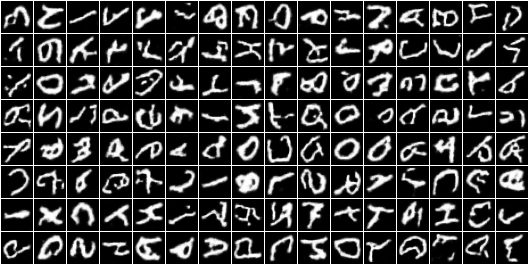

[9/50] - ptime: 50.61, loss_d: 0.835, loss_g: 1.162
tensor(0.0077)


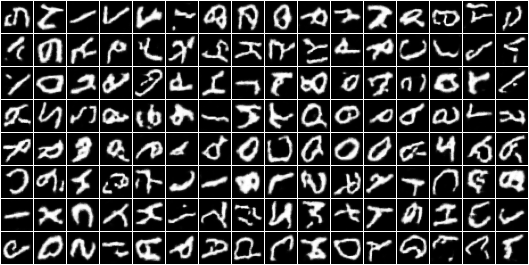

[9/50] - ptime: 188.74, loss_d: 0.853, loss_g: 1.167
tensor(0.0073)


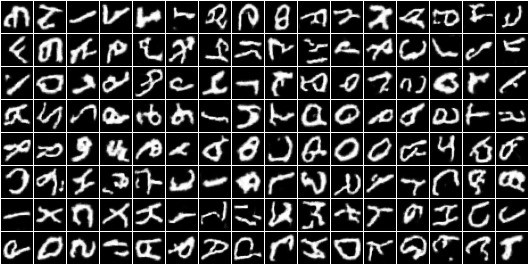

[10/50] - ptime: 22.32, loss_d: 0.809, loss_g: 1.184
tensor(0.0066)


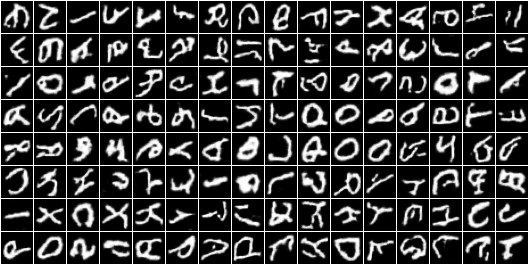

[10/50] - ptime: 160.52, loss_d: 0.832, loss_g: 1.189
tensor(0.0063)


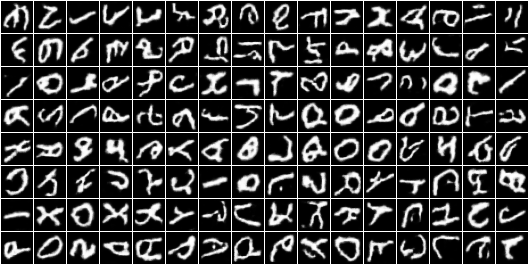

[10/50] - ptime: 298.72, loss_d: 0.832, loss_g: 1.186
tensor(0.0059)


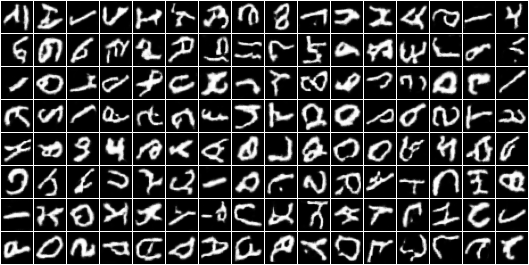

[11/50] - ptime: 132.00, loss_d: 0.828, loss_g: 1.184
tensor(0.0057)


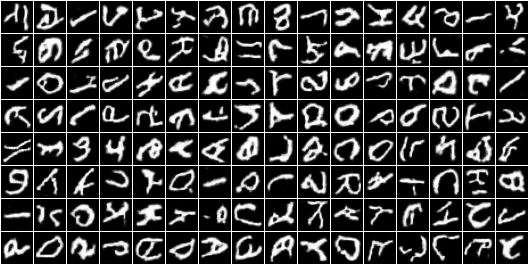

[11/50] - ptime: 270.24, loss_d: 0.832, loss_g: 1.186
tensor(0.0056)


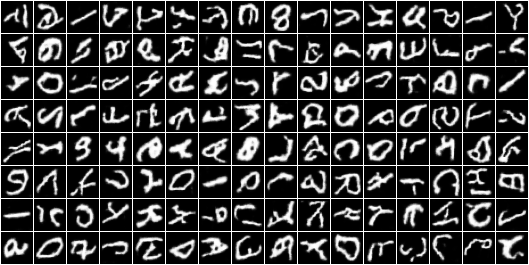

[12/50] - ptime: 103.74, loss_d: 0.804, loss_g: 1.198
tensor(0.0046)


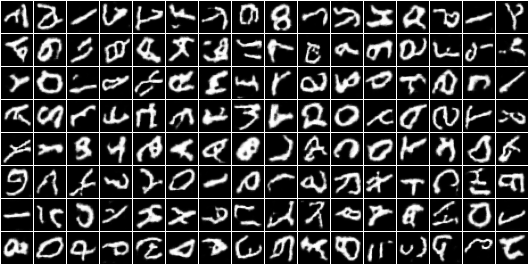

[12/50] - ptime: 241.96, loss_d: 0.802, loss_g: 1.206
tensor(0.0046)


KeyboardInterrupt: 

In [42]:
show_step = 200

# network
G = generator(128, n_classes=n_classes)
D = discriminator(128, n_classes=n_classes)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()
NLL_loss = nn.NLLLoss()

print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    R_losses = []
    
    G_optimizer.param_groups[0]['lr'] = lr * (0.1 ** (epoch / 30))
    D_optimizer.param_groups[0]['lr'] = lr * (0.1 ** (epoch / 30))

    epoch_start_time = time.time()
    y_real = torch.ones(batch_size).cuda()
    y_fake = torch.zeros(batch_size).cuda()
    
    for i, (images, y) in enumerate(tqdm_notebook(dataloader)):
        images = images.cuda()
        
        #--------------------------------------------------
        # train discriminator
        #--------------------------------------------------
        D.zero_grad()
        mini_batch = images.size()[0]

        if mini_batch != batch_size:
            y_real = torch.ones(mini_batch).cuda()
            y_fake = torch.zeros(mini_batch).cuda()
        
        # Train desciminator on real images.
        D_result, _ = D(images)
        D_real_loss = BCE_loss(D_result.squeeze(), y_real)

        # Train desciminator on fake, generated images.
        z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        y = (torch.rand(mini_batch) * n_classes).long()
        y_label_ = onehot[y].cuda()

        G_result = G(z, y_label_)
        D_result, D_recover = D(G_result)
        D_fake_loss = BCE_loss(D_result.squeeze(), y_fake)
        D_recover_loss = NLL_loss(D_recover.squeeze(), y.cuda())

        # Total loss is normal GAN (classifying fake + classifying real.) + recovery.
        D_train_loss = D_recover_loss + D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss)
        R_losses.append(D_recover_loss)
        
        #--------------------------------------------------
        # train generator
        #--------------------------------------------------
        G.zero_grad()

        z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        y = (torch.rand(mini_batch) * n_classes).long()
        
        G_result = G(z, onehot[y].cuda())
        D_result, D_recover = D(G_result)

        G_train_loss = BCE_loss(D_result.squeeze(), y_real)
        G_recover_loss = NLL_loss(D_recover.squeeze(), y.cuda())
        
        # Loss is normal GAN G loss + recovery.
        G_loss = G_recover_loss + G_train_loss
        
        G_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss)
        R_losses.append(G_recover_loss)
        
        ii = epoch*len(dataloader) + i
        if ii%show_step == 0:
            show_result(G, path=root + str(ii // show_step) + '.png')
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - epoch_start_time

            print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % \
                  ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                      torch.mean(torch.FloatTensor(G_losses))))
            
            print(torch.mean(torch.FloatTensor(R_losses)))
            
            train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
            train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
            train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

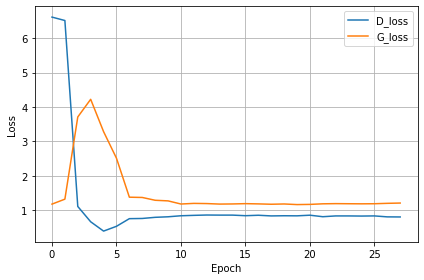

In [45]:
show_train_hist(train_hist, show=True, save=True, path=root + 'train_hist.png')

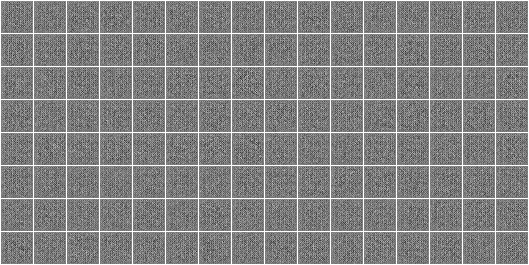

In [49]:
images = []
for e in range(train_epoch):
    img_name = root + str(e) + '.png'
    if os.path.exists(img_name):
        images.append(imageio.imread(img_name))
imageio.mimsave(root + 'generation_animation.gif', images, fps=5)
display(Image(root + 'generation_animation.gif'))

In [ ]:
# torch.save(G.state_dict(), 'EMNIST_generator_param.pkl')
# torch.save(D.state_dict(), 'EMNIST_discriminator_param.pkl')